# Visualize Code Generation Results - Pre-Agentic Baseline Results

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# PART 1. Load Results and Scale the Four Datasets

In [2]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250529.xlsx'
sheet_names = ['HumanEval', 'BigCode', 'MBPP', 'LBPP',]
res_raw = dict()
for sheet_name in sheet_names:
    res_raw[sheet_name] = pd.read_excel( file, sheet_name=sheet_name )
print('Datasets:', ', '.join(list(res_raw.keys())))
print(res_raw['HumanEval'].shape)
res_raw['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP
(12, 21)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,phixtral-4x2_8,Solar-10.7B,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_7b,mistral_3b,mistral_8B,mistral_nemo,codestral_mamba
0,1,human_eval,basic_prompt,raw,1,1,0.500000,0.500000,0.054878,0.000000,0.000000,0.774390,0.743902,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.487805,0.439024
1,2,human_eval,basic_prompt,partial,1,1,0.500000,0.500000,0.451220,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.420732,0.774390,0.792683,0.689024,0.737805
2,3,human_eval,basic_prompt,full,1,1,0.512195,0.512195,0.451220,0.707317,0.609756,0.780488,0.762195,0.750000,0.823171,0.829268,0.420732,0.768293,0.786585,0.682927,0.762195
3,4,human_eval,basic_prompt,full_light,1,1,0.506098,0.506098,0.451220,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.420732,0.774390,0.792683,0.689024,0.762195
4,5,human_eval,prompt,raw,1,1,0.024390,0.024390,0.000000,0.000000,0.000000,0.024390,0.006098,0.725610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,human_eval,prompt,partial,1,1,0.463415,0.463415,0.445122,0.658537,0.554878,0.817073,0.768293,0.768293,0.786585,0.768293,0.317073,0.091463,0.804878,0.695122,0.621951
6,7,human_eval,prompt,full,1,1,0.554878,0.554878,0.445122,0.682927,0.585366,0.810976,0.762195,0.762195,0.841463,0.829268,0.359756,0.756098,0.804878,0.689024,0.750000
7,8,human_eval,prompt,full_light,1,1,0.560976,0.560976,0.445122,0.670732,0.585366,0.817073,0.768293,0.768293,0.841463,0.829268,0.359756,0.756098,0.804878,0.695122,0.750000
8,9,human_eval,full_prompt,raw,1,1,0.048780,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.609756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006098
9,10,human_eval,full_prompt,partial,1,1,0.256098,0.256098,0.341463,0.585366,0.512195,0.725610,0.713415,0.682927,0.756098,0.750000,0.317073,0.640244,0.731707,0.323171,0.530488


In [3]:
# select 15 SLM model columns and add index for convenience
res_raw_short = dict()
for key in res_raw:
    df = res_raw[key]
    param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
    score_cols = [c for c in df.columns if c not in param_cols]
    res_raw_short[key] = df[score_cols].apply(pd.to_numeric, errors='coerce')

    # Rebuild MultiIndex on rows from the original prompt/cleaning columns
    mi = pd.MultiIndex.from_frame(df[['prompt','cleaning']])
    res_raw_short[key].index = mi
    res_raw_short[key].index.names = ['prompt','cleaning']
print('Datasets:', ', '.join(list(res_raw_short.keys())))
print(res_raw_short['HumanEval'].shape)
res_raw_short['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP
(12, 15)


phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw               0.500000        0.500000     0.054878   
             partial           0.500000        0.500000     0.451220   
             full              0.512195        0.512195     0.451220   
             full_light        0.506098        0.506098     0.451220   
prompt       raw               0.024390        0.024390     0.000000   
             partial           0.463415        0.463415     0.445122   
             full              0.554878        0.554878     0.445122   
             full_light        0.560976        0.560976     0.445122   
full_prompt  raw               0.048780        0.048780     0.000000   
             partial           0.256098        0.256098     0.341463   
             full              0.548780        0.548780     0.414634   
             full_light        0.542683        0.542683     0.414634   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw             0.000000         0.000000             0.774390   
             partial         0.701220         0.609756             0.786585   
             full            0.707317         0.609756             0.780488   
             full_light      0.701220         0.609756             0.786585   
prompt       raw             0.000000         0.000000             0.024390   
             partial         0.658537         0.554878             0.817073   
             full            0.682927         0.585366             0.810976   
             full_light      0.670732         0.585366             0.817073   
full_prompt  raw             0.000000         0.000000             0.000000   
             partial         0.585366         0.512195             0.725610   
             full            0.585366         0.542683             0.725610   
             full_light      0.585366         0.542683             0.725610   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                            0.743902                0.750000   
             partial                        0.762195                0.756098   
             full                           0.762195                0.750000   
             full_light                     0.762195                0.756098   
prompt       raw                            0.006098                0.725610   
             partial                        0.768293                0.768293   
             full                           0.762195                0.762195   
             full_light                     0.768293                0.768293   
full_prompt  raw                            0.000000                0.609756   
             partial                        0.713415                0.682927   
             full                           0.719512                0.695122   
             full_light                     0.719512                0.695122   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                    0.000000           0.000000    0.000000   
             partial                0.817073           0.823171    0.420732   
             full                   0.823171           0.829268    0.420732   
             full_light             0.817073           0.823171    0.420732   
prompt       raw                    0.000000           0.000000    0.000000   
             partial                0.786585           0.768293    0.317073   
             full                   0.841463           0.829268    0.359756   
             full_light             0.841463           0.829268    0.359756  

In [4]:
for key, df in res_raw_short.items():
    print(key)
    max_val = df.max().max()
    
    # Find row and column of the max value
    full_idx = (df == max_val).stack().idxmax()

    print(f'Max: {max_val:.4f}')
    print(full_idx)

    # get mean value for 'full' and 'full_light' rows
    filtered = pd.concat([
    df.xs('full', level='cleaning', drop_level=False),
    df.xs('full_light', level='cleaning', drop_level=False)
    ])
    row_means = filtered.mean(axis=1)
    overall_mean = row_means.mean()
    print(f"Mean of row-wise means for 'full' and 'full_light': {overall_mean:.4f}\n")

HumanEval
Max: 0.8415
('prompt', 'full', 'CodeQwen1.5-7B-Chat')
Mean of row-wise means for 'full' and 'full_light': 0.6614

BigCode
Max: 0.3720
('full_prompt', 'partial', 'mistral_7b')
Mean of row-wise means for 'full' and 'full_light': 0.2681

MBPP
Max: 0.7400
('prompt', 'partial', 'Nxcode-CQ-7B-orpo')
Mean of row-wise means for 'full' and 'full_light': 0.5636

LBPP
Max: 0.2963
('basic_prompt', 'partial', 'Llama-3.1-8B')
Mean of row-wise means for 'full' and 'full_light': 0.2134



In [5]:
# scale scores in each dataframe
res = dict()
for key, df in res_raw_short.items():
    scaled_df = (df - df.min().min()) / (df.max().max() - df.min().min())
    res[key] = scaled_df
print('Datasets:', ', '.join(list(res.keys())))
print(res['HumanEval'].shape)
res['MBPP']

Datasets: HumanEval, BigCode, MBPP, LBPP
(12, 15)


phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw               0.000000        0.000000     0.016216   
             partial           0.645946        0.645946     0.605405   
             full              0.648649        0.648649     0.605405   
             full_light        0.645946        0.645946     0.605405   
prompt       raw               0.000000        0.000000     0.000000   
             partial           0.672973        0.672973     0.581081   
             full              0.672973        0.672973     0.581081   
             full_light        0.672973        0.672973     0.581081   
full_prompt  raw               0.002703        0.002703     0.000000   
             partial           0.629730        0.629730     0.535135   
             full              0.645946        0.645946     0.537838   
             full_light        0.645946        0.645946     0.537838   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw             0.027027         0.000000             0.000000   
             partial         0.808108         0.721622             0.859459   
             full            0.816216         0.721622             0.870270   
             full_light      0.808108         0.721622             0.859459   
prompt       raw             0.000000         0.000000             0.000000   
             partial         0.708108         0.721622             0.827027   
             full            0.762162         0.721622             0.829730   
             full_light      0.762162         0.721622             0.827027   
full_prompt  raw             0.000000         0.000000             0.000000   
             partial         0.786486         0.713514             0.851351   
             full            0.821622         0.713514             0.851351   
             full_light      0.821622         0.713514             0.851351   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                            0.145946                0.008108   
             partial                        0.851351                0.875676   
             full                           0.851351                0.875676   
             full_light                     0.851351                0.875676   
prompt       raw                            0.000000                0.000000   
             partial                        0.862162                0.824324   
             full                           0.862162                0.824324   
             full_light                     0.862162                0.824324   
full_prompt  raw                            0.000000                0.000000   
             partial                        0.859459                0.835135   
             full                           0.859459                0.837838   
             full_light                     0.859459                0.837838   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                    0.000000           0.000000    0.000000   
             partial                0.991892           0.986486    0.554054   
             full                   0.991892           0.986486    0.570270   
             full_light             0.991892           0.986486    0.554054   
prompt       raw                    0.000000           0.000000    0.000000   
             partial                0.991892           1.000000    0.500000   
             full                   0.991892           1.000000    0.500000   
             full_light             0.991892           1.000000    0.500000  

# PART 2. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 2.1 Select the best cleaning method

### 2.1.1 Approach 1

In [6]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.mean()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.63349
Difference between full_light and raw: 0.63382
Overall difference:                    -0.00032

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.804831    0.804831  0.801932  0.336715
full_prompt   0.745411    0.744444  0.643478  0.056522
prompt        0.807246    0.809179  0.714976  0.063768
mean          0.785829    0.786151  0.720129  0.152335


Dataset: BigCode

Cleaning method with the highest mean score: full
Difference between full and raw:       0.67754
Difference between full_light and raw: 0.64576
Overall difference:                    0.03178

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.759498    0.710753  0.697849  0.155914
full_prompt   0.671326    0.656272  0.549462  0.012545
prompt        0.778

In [7]:
full = (0.63349+0.67754+0.75742+0.70324)
full_light = (0.63382+0.64576+0.75634+0.72407)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       2.7716900000000004
Full light cleaning: 2.75999


__The full cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, althought the two methods are really close to each other in terms of the results.

### 2.1.2 Approach 2

In [9]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).mean()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full          10
full_light     4
partial        1
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
Solar-10.7B,0.026779,0.506588,0.541726,0.541278,full,2.0
mistral_7b,0.000000,0.560808,0.559948,0.556413,partial,1.0
phixtral-2x2_8,0.095239,0.512159,0.621591,0.602225,full,2.0
phixtral-4x2_8,0.095239,0.511711,0.622039,0.602673,full,2.0
Codegemma-7b-it,0.000000,0.673526,0.702022,0.703758,full_light,3.0
mistral_nemo,0.048757,0.674102,0.715293,0.704963,full,2.0
Llama-3.1-8B,0.002700,0.755044,0.777037,0.777630,full_light,3.0
mistral_3b,0.000000,0.578975,0.792011,0.808632,full_light,3.0
OpenCodeInterpreter-DS-6.7B,0.118192,0.804468,0.825582,0.820305,full,2.0
deepseek-coder-6.7b,0.099716,0.778240,0.830018,0.818003,full,2.0


__The full cleaning method wins again__, this time in a more evident way. BOTH APPROACHES RESULT IN THE FULL CLEANING METHOD BEING THE WINNER.

In [34]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  \
dataset cleaning                                                                
ds1     full              0.958333        0.958333     0.968468      0.931034   
        full_light        0.954545        0.954545     0.968468      0.922414   
        partial           0.712121        0.712121     0.914414      0.916667   
        raw               0.310606        0.310606     0.040541      0.000000   
ds2     full              0.879902        0.882353     0.941315      0.875556   
        full_light        0.750000        0.752451     0.938967      0.813333   
        partial           0.495098        0.492647     0.960094      0.804444   
        raw               0.154412        0.154412     0.077465      0.002222   
ds3     full              0.974565        0.974565     0.949405      0.973684   
        full_light        0.973226        0.973226     0.949405      0.970395   
        partial           0.965194        0.965194     0.947917      0.934211   
        raw               0.001339        0.001339     0.008929      0.010965   
ds4     full              0.896552        0.896552     0.894737      0.819444   
        full_light        0.931034        0.931034     0.894737      0.881944   
        partial           0.908046        0.908046     0.578947      0.833333   
        raw               0.057471        0.057471     0.052632      0.000000   

                    Codegemma-7b-it  deepseek-coder-6.7b  \
dataset cleaning                                           
ds1     full               0.950000             0.945274   
        full_light         0.950000             0.950249   
        partial            0.916667             0.950249   
        raw                0.000000             0.325871   
ds2     full               0.940898             0.957494   
        full_light         0.940898             0.897092   
        partial            0.959811             0.715884   
        raw                0.000000             0.102908   
ds3     full               0.996255             0.977226   
        full_light         0.996255             0.972050   
        partial            0.996255             0.972050   
        raw                0.000000             0.000000   
ds4     full               0.916667             0.991228   
        full_light         0.925926             0.991228   
        partial            0.777778             0.973684   
        raw                0.000000             0.000000   

                    OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset cleaning                                                          
ds1     full                           0.973545                0.794872   
        full_light                     0.976190                0.820513   
        partial                        0.973545                0.794872   
        raw                            0.325397                0.538462   
ds2     full                           0.864368                0.932836   
        full_light                     0.825287                0.883085   
        partial                        0.747126                0.873134   
        raw                            0.154023                0.348259   
ds3     full                           0.994775                0.966049   
        full_light                     0.994775                0.966049   
        partial                        0.994775                0.965021   
        raw                            0.056426                0.003086   
ds4     full                           0.920290                0.944444   
        full_light                     0.927536                0.951389   
        partial                        0.927536                0.951389   
        raw                            0.007246                0.000000   

                    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset cleaning                                       

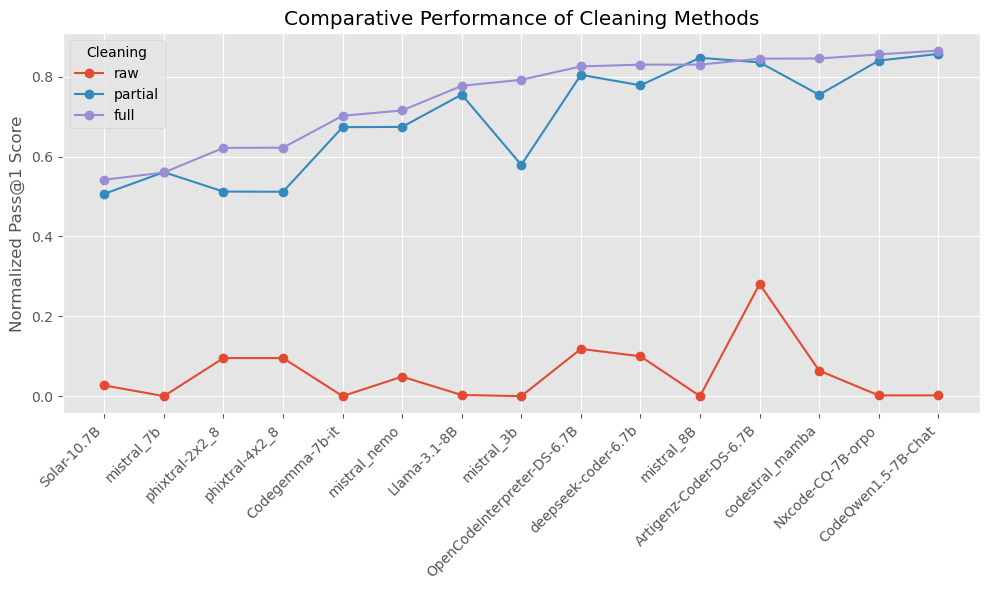

In [11]:
# visualize cleaning method performance
plt.style.use('ggplot')
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 2.2 Select the best prompting strategy

In [13]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
basic_prompt    9
prompt          6
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
Solar-10.7B,0.561787,0.544990,0.518401,basic_prompt,0.0
mistral_7b,0.589476,0.572106,0.518262,basic_prompt,0.0
phixtral-2x2_8,0.604155,0.657863,0.602756,prompt,1.0
phixtral-4x2_8,0.605499,0.657863,0.602756,prompt,1.0
Codegemma-7b-it,0.697922,0.714365,0.693777,prompt,1.0
mistral_nemo,0.799850,0.770507,0.575523,basic_prompt,0.0
mistral_3b,0.815625,0.779999,0.780409,basic_prompt,0.0
Llama-3.1-8B,0.820449,0.712323,0.798337,basic_prompt,0.0
deepseek-coder-6.7b,0.834196,0.841352,0.814506,prompt,1.0
mistral_8B,0.844990,0.825150,0.819989,basic_prompt,0.0


In [33]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
CodeQwen1.5-7B-Chat,0.885347,0.897335,0.812829,0.865170
Nxcode-CQ-7B-orpo,0.873879,0.887842,0.805148,0.855623
codestral_mamba,0.852342,0.833569,0.850472,0.845461
Artigenz-Coder-DS-6.7B,0.877397,0.858942,0.798542,0.844960
mistral_8B,0.844990,0.825150,0.819989,0.830043
deepseek-coder-6.7b,0.834196,0.841352,0.814506,0.830018
OpenCodeInterpreter-DS-6.7B,0.848225,0.845216,0.783304,0.825582
mistral_3b,0.815625,0.779999,0.780409,0.792011
Llama-3.1-8B,0.820449,0.712323,0.798337,0.777037
mistral_nemo,0.799850,0.770507,0.575523,0.715293


In [24]:
combined.head(25)

phixtral-2x2_8  phixtral-4x2_8  \
dataset   prompt       cleaning                                     
HumanEval basic_prompt raw               0.594203        0.594203   
                       partial           0.594203        0.594203   
                       full              0.608696        0.608696   
                       full_light        0.601449        0.601449   
          prompt       raw               0.028986        0.028986   
                       partial           0.550725        0.550725   
                       full              0.659420        0.659420   
                       full_light        0.666667        0.666667   
          full_prompt  raw               0.057971        0.057971   
                       partial           0.304348        0.304348   
                       full              0.652174        0.652174   
                       full_light        0.644928        0.644928   
BigCode   basic_prompt raw               0.306452        0.306452   
                       partial           0.317204        0.311828   
                       full              0.596774        0.602151   
                       full_light        0.397849        0.403226   
          prompt       raw               0.005376        0.005376   
                       partial           0.704301        0.704301   
                       full              0.736559        0.736559   
                       full_light        0.725806        0.725806   
          full_prompt  raw               0.043011        0.043011   
                       partial           0.080645        0.080645   
                       full              0.612903        0.612903   
                       full_light        0.537634        0.537634   
MBPP      basic_prompt raw               0.000000        0.000000   

                                   Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
dataset   prompt       cleaning                                                 
HumanEval basic_prompt raw            0.065217      0.000000         0.000000   
                       partial        0.536232      0.833333         0.724638   
                       full           0.536232      0.840580         0.724638   
                       full_light     0.536232      0.833333         0.724638   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.528986      0.782609         0.659420   
                       full           0.528986      0.811594         0.695652   
                       full_light     0.528986      0.797101         0.695652   
          full_prompt  raw            0.000000      0.000000         0.000000   
                       partial        0.405797      0.695652         0.608696   
                       full           0.492754      0.695652         0.644928   
                       full_light     0.492754      0.695652         0.644928   
BigCode   basic_prompt raw            0.177419      0.000000         0.000000   
                       partial        0.698925      0.586022         0.715054   
                       full           0.709677      0.666667         0.720430   
                       full_light     0.704301      0.607527         0.720430   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.736559      0.553763         0.758065   
                       full           0.736559      0.650538         0.752688   
                       full_light     0.736559      0.559140         0.752688   
          full_prompt  raw            0.000000      0.005376         0.000000   
                       partial        0.763441      0.806452         0.709677   
                       full           0.709677      0.801075         0.666667   
                       full_light     0.709677      0.801075         0.666667   
MBPP      basic_prompt raw            0.016216      0.027027     

In [22]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
dataset   prompt                                                      
HumanEval basic_prompt        0.608696        0.608696     0.536232   
          prompt              0.659420        0.659420     0.528986   
          full_prompt         0.652174        0.652174     0.492754   
BigCode   basic_prompt        0.596774        0.602151     0.709677   
          prompt              0.736559        0.736559     0.736559   
          full_prompt         0.612903        0.612903     0.709677   
MBPP      basic_prompt        0.648649        0.648649     0.605405   
          prompt              0.672973        0.672973     0.581081   
          full_prompt         0.645946        0.645946     0.537838   
LBPP      basic_prompt        0.562500        0.562500     0.395833   
          prompt              0.562500        0.562500     0.333333   
          full_prompt         0.500000        0.500000     0.333333   

                        Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
dataset   prompt                                                             
HumanEval basic_prompt      0.840580         0.724638             0.927536   
          prompt            0.811594         0.695652             0.963768   
          full_prompt       0.695652         0.644928             0.862319   
BigCode   basic_prompt      0.666667         0.720430             0.747312   
          prompt            0.650538         0.752688             0.801075   
          full_prompt       0.801075         0.666667             0.752688   
MBPP      basic_prompt      0.816216         0.721622             0.870270   
          prompt            0.762162         0.721622             0.829730   
          full_prompt       0.821622         0.713514             0.851351   
LBPP      basic_prompt      0.958333         0.625000             0.791667   
          prompt            0.625000         0.687500             0.770833   
          full_prompt       0.875000         0.750000             0.791667   

                        OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset   prompt                                                              
HumanEval basic_prompt                     0.905797                0.891304   
          prompt                           0.905797                0.905797   
          full_prompt                      0.855072                0.826087   
BigCode   basic_prompt                     0.677419                0.763441   
          prompt                           0.779570                0.747312   
          full_prompt                      0.564516                0.634409   
MBPP      basic_prompt                     0.851351                0.875676   
          prompt                           0.862162                0.824324   
          full_prompt                      0.859459                0.837838   
LBPP      basic_prompt                     0.958333                0.979167   
          prompt                           0.833333                0.958333   
          full_prompt                      0.854167                0.895833   

                        CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset   prompt                                                             
HumanEval basic_prompt             0.978261           0.985507    0.500000   
          prompt                   1.000000           0.985507    0.427536   
          full_prompt              0.927536           0.920290    0.442029   
BigCode   basic_prompt             0.779570           0.752688    0.870968   
          prompt                   0.784946           0.774194    0.881720   
          full_prompt              0.559140           0.548387    0.865591   
MBPP      basic_prompt             0.991892           0.986486    0.570270   
          prompt                   0.991892           1.000000    0.500000   
          full_prompt              0.972973      

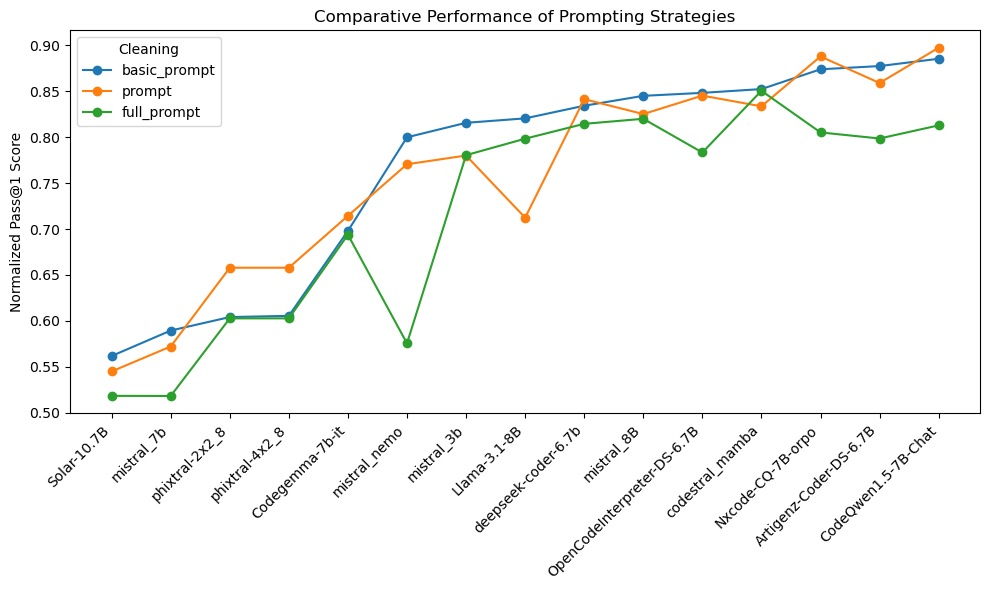

In [16]:
# visualize prompting strategy performance
plot_df = final_prompt_df.drop(index='mean')
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [14]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.mean(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval,BigCode,MBPP,LBPP,Mean
prompt,,,,,
basic_prompt,0.804831,0.759498,0.778919,0.726389,0.767409
prompt,0.807246,0.778853,0.755135,0.698611,0.759961
full_prompt,0.745411,0.671326,0.752432,0.704167,0.718334
mean,0.785829,0.736559,0.762162,0.709722,0.748568


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 2.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [15]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval,BigCode,MBPP,LBPP,mean
CodeQwen1.5-7B-Chat,0.978261,0.779570,0.991892,0.791667,0.885347
Artigenz-Coder-DS-6.7B,0.891304,0.763441,0.875676,0.979167,0.877397
Nxcode-CQ-7B-orpo,0.985507,0.752688,0.986486,0.770833,0.873879
codestral_mamba,0.905797,0.860215,0.789189,0.854167,0.852342
OpenCodeInterpreter-DS-6.7B,0.905797,0.677419,0.851351,0.958333,0.848225
mistral_8B,0.934783,0.892473,0.802703,0.750000,0.844990
deepseek-coder-6.7b,0.927536,0.747312,0.870270,0.791667,0.834196
Llama-3.1-8B,0.840580,0.666667,0.816216,0.958333,0.820449
mistral_3b,0.913043,0.892473,0.748649,0.708333,0.815625
mistral_nemo,0.811594,0.860215,0.756757,0.770833,0.799850


In [16]:
combined.head(25)

phixtral-2x2_8  phixtral-4x2_8  \
dataset   prompt       cleaning                                     
HumanEval basic_prompt raw               0.594203        0.594203   
                       partial           0.594203        0.594203   
                       full              0.608696        0.608696   
                       full_light        0.601449        0.601449   
          prompt       raw               0.028986        0.028986   
                       partial           0.550725        0.550725   
                       full              0.659420        0.659420   
                       full_light        0.666667        0.666667   
          full_prompt  raw               0.057971        0.057971   
                       partial           0.304348        0.304348   
                       full              0.652174        0.652174   
                       full_light        0.644928        0.644928   
BigCode   basic_prompt raw               0.306452        0.306452   
                       partial           0.317204        0.311828   
                       full              0.596774        0.602151   
                       full_light        0.397849        0.403226   
          prompt       raw               0.005376        0.005376   
                       partial           0.704301        0.704301   
                       full              0.736559        0.736559   
                       full_light        0.725806        0.725806   
          full_prompt  raw               0.043011        0.043011   
                       partial           0.080645        0.080645   
                       full              0.612903        0.612903   
                       full_light        0.537634        0.537634   
MBPP      basic_prompt raw               0.000000        0.000000   

                                   Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
dataset   prompt       cleaning                                                 
HumanEval basic_prompt raw            0.065217      0.000000         0.000000   
                       partial        0.536232      0.833333         0.724638   
                       full           0.536232      0.840580         0.724638   
                       full_light     0.536232      0.833333         0.724638   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.528986      0.782609         0.659420   
                       full           0.528986      0.811594         0.695652   
                       full_light     0.528986      0.797101         0.695652   
          full_prompt  raw            0.000000      0.000000         0.000000   
                       partial        0.405797      0.695652         0.608696   
                       full           0.492754      0.695652         0.644928   
                       full_light     0.492754      0.695652         0.644928   
BigCode   basic_prompt raw            0.177419      0.000000         0.000000   
                       partial        0.698925      0.586022         0.715054   
                       full           0.709677      0.666667         0.720430   
                       full_light     0.704301      0.607527         0.720430   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.736559      0.553763         0.758065   
                       full           0.736559      0.650538         0.752688   
                       full_light     0.736559      0.559140         0.752688   
          full_prompt  raw            0.000000      0.005376         0.000000   
                       partial        0.763441      0.806452         0.709677   
                       full           0.709677      0.801075         0.666667   
                       full_light     0.709677      0.801075         0.666667   
MBPP      basic_prompt raw            0.016216      0.027027     

In [27]:
best_case_df

,phixtral-2x2_8,phixtral-4x2_8,Solar-10.7B,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_7b,mistral_3b,mistral_8B,mistral_nemo,codestral_mamba
dataset,,,,,,,,,,,,,,,
HumanEval,0.608696,0.608696,0.536232,0.840580,0.724638,0.927536,0.905797,0.891304,0.978261,0.985507,0.500000,0.913043,0.934783,0.811594,0.905797
BigCode,0.596774,0.602151,0.709677,0.666667,0.720430,0.747312,0.677419,0.763441,0.779570,0.752688,0.870968,0.892473,0.892473,0.860215,0.860215
MBPP,0.648649,0.648649,0.605405,0.816216,0.721622,0.870270,0.851351,0.875676,0.991892,0.986486,0.570270,0.748649,0.802703,0.756757,0.789189
LBPP,0.562500,0.562500,0.395833,0.958333,0.625000,0.791667,0.958333,0.979167,0.791667,0.770833,0.416667,0.708333,0.750000,0.770833,0.854167


## Average across all prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [20]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').mean()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)
model_perf_df.loc['mean'] = model_perf_df.mean()

# View result
model_perf_df

dataset,BigCode,HumanEval,LBPP,MBPP,mean
CodeQwen1.5-7B-Chat,0.707885,0.968599,0.798611,0.985586,0.865170
Nxcode-CQ-7B-orpo,0.691756,0.963768,0.777778,0.989189,0.855623
codestral_mamba,0.817204,0.888889,0.902778,0.772973,0.845461
Artigenz-Coder-DS-6.7B,0.715054,0.874396,0.944444,0.845946,0.844960
mistral_8B,0.885305,0.922705,0.750000,0.762162,0.830043
deepseek-coder-6.7b,0.767025,0.917874,0.784722,0.850450,0.830018
OpenCodeInterpreter-DS-6.7B,0.673835,0.888889,0.881944,0.857658,0.825582
mistral_3b,0.881720,0.886473,0.694444,0.705405,0.792011
Llama-3.1-8B,0.706093,0.782609,0.819444,0.800000,0.777037
mistral_nemo,0.598566,0.748792,0.777778,0.736036,0.715293


# PART 3. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 3.1 Select the best cleaning method

### 3.1.1 Approach 1

In [35]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.max()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.47053
Difference between full_light and raw: 0.47246
Overall difference:                    -0.00193

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.804831    0.804831  0.801932  0.336715
full_prompt   0.745411    0.744444  0.643478  0.056522
prompt        0.807246    0.809179  0.714976  0.063768
mean          0.807246    0.809179  0.801932  0.336715


Dataset: BigCode

Cleaning method with the highest mean score: full
Difference between full and raw:       0.62294
Difference between full_light and raw: 0.59140
Overall difference:                    0.03154

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.759498    0.710753  0.697849  0.155914
full_prompt   0.671326    0.656272  0.549462  0.012545
prompt        0.778

In [36]:
full = (0.47053+0.62294+0.76505+0.70694)
full_light = (0.47246+0.59140+0.76216+0.73611)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       2.56546
Full light cleaning: 2.56213


__The full cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, but the difference is minimal.

### 3.1.2 Approach 2

In [38]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).max()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full          7
partial       4
full_light    4
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
Solar-10.7B,0.080338,0.538770,0.568507,0.568507,full,2.0
mistral_7b,0.000000,0.622889,0.607789,0.603735,partial,1.0
phixtral-2x2_8,0.251881,0.638703,0.657863,0.667403,full_light,3.0
phixtral-4x2_8,0.251881,0.638703,0.657863,0.667403,full_light,3.0
Codegemma-7b-it,0.000000,0.707331,0.737237,0.737237,full,2.0
mistral_nemo,0.146272,0.804481,0.806870,0.811034,full_light,3.0
mistral_3b,0.000000,0.836925,0.815625,0.836925,partial,1.0
Llama-3.1-8B,0.008101,0.861973,0.855402,0.864008,full_light,3.0
deepseek-coder-6.7b,0.290556,0.830266,0.856695,0.843707,full,2.0
mistral_8B,0.000000,0.908384,0.860841,0.905696,partial,1.0


__Partial wins when aggregating by max() both time__.  
__Full wins when doing max() first time and mean() the second gtime in the code above__

In [39]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
dataset   cleaning                                                  
BigCode   full              0.736559        0.736559     0.736559   
          full_light        0.725806        0.725806     0.736559   
          partial           0.704301        0.704301     0.763441   
          raw               0.306452        0.306452     0.177419   
HumanEval full              0.659420        0.659420     0.536232   
          full_light        0.666667        0.666667     0.536232   
          partial           0.594203        0.594203     0.536232   
          raw               0.594203        0.594203     0.065217   
LBPP      full              0.562500        0.562500     0.395833   
          full_light        0.604167        0.604167     0.395833   
          partial           0.583333        0.583333     0.250000   
          raw               0.104167        0.104167     0.062500   
MBPP      full              0.672973        0.672973     0.605405   
          full_light        0.672973        0.672973     0.605405   
          partial           0.672973        0.672973     0.605405   
          raw               0.002703        0.002703     0.016216   

                      Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
dataset   cleaning                                                         
BigCode   full            0.801075         0.752688             0.801075   
          full_light      0.801075         0.752688             0.752688   
          partial         0.806452         0.758065             0.698925   
          raw             0.005376         0.000000             0.241935   
HumanEval full            0.840580         0.724638             0.963768   
          full_light      0.833333         0.724638             0.971014   
          partial         0.833333         0.724638             0.971014   
          raw             0.000000         0.000000             0.920290   
LBPP      full            0.958333         0.750000             0.791667   
          full_light      1.000000         0.750000             0.791667   
          partial         1.000000         0.625000             0.791667   
          raw             0.000000         0.000000             0.000000   
MBPP      full            0.821622         0.721622             0.870270   
          full_light      0.821622         0.721622             0.859459   
          partial         0.808108         0.721622             0.859459   
          raw             0.027027         0.000000             0.000000   

                      OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset   cleaning                                                          
BigCode   full                           0.779570                0.763441   
          full_light                     0.768817                0.736559   
          partial                        0.752688                0.736559   
          raw                            0.354839                0.731183   
HumanEval full                           0.905797                0.905797   
          full_light                     0.913043                0.913043   
          partial                        0.913043                0.913043   
          raw                            0.884058                0.891304   
LBPP      full                           0.958333                0.979167   
          full_light                     0.937500                1.000000   
          partial                        0.937500                1.000000   
          raw                            0.020833                0.000000   
MBPP      full                           0.862162                0.875676   
          full_light                     0.862162                0.875676   
          partial                        0.862162                0.875676   
          raw                            0.145946                0.008108   

                      C

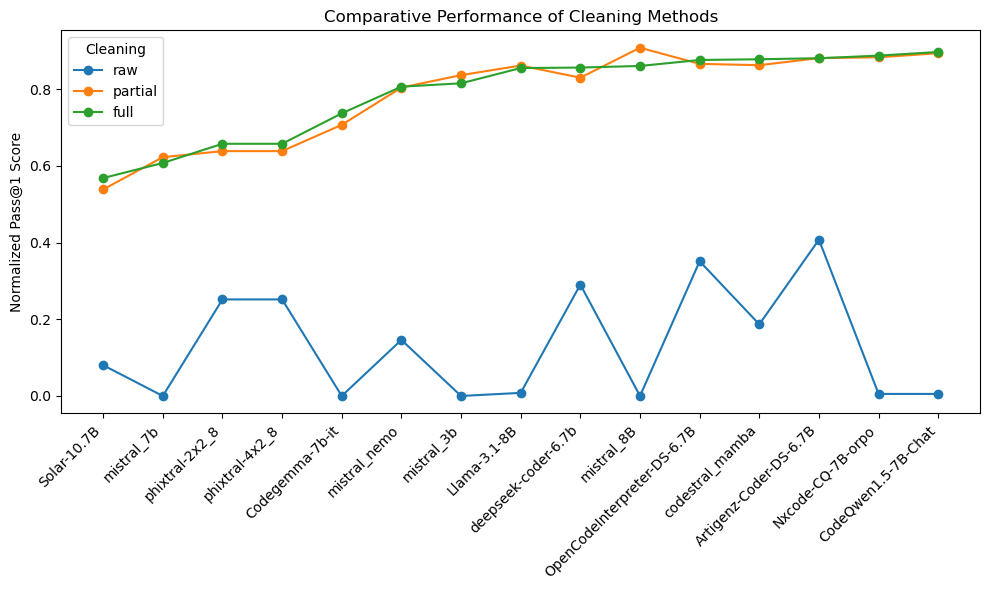

In [40]:
# visualize cleaning method performance
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 3.2 Select the best prompting strategy

In [41]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
prompt          9
basic_prompt    5
full_prompt     1
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
phixtral-2x2_8,0.648649,0.736559,0.652174,prompt,1.000000
phixtral-4x2_8,0.648649,0.736559,0.652174,prompt,1.000000
Solar-10.7B,0.709677,0.736559,0.709677,prompt,1.000000
Codegemma-7b-it,0.724638,0.752688,0.750000,prompt,1.000000
mistral_nemo,0.860215,0.818841,0.770833,basic_prompt,0.000000
mistral_7b,0.870968,0.881720,0.865591,prompt,1.000000
codestral_mamba,0.905797,0.895833,0.958333,full_prompt,2.000000
mistral_3b,0.913043,0.898551,0.887097,basic_prompt,0.000000
deepseek-coder-6.7b,0.927536,0.963768,0.862319,prompt,1.000000
mistral_8B,0.934783,0.956522,0.876812,prompt,1.000000


In [42]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
Nxcode-CQ-7B-orpo,0.986486,1.000000,0.981081,0.989189
CodeQwen1.5-7B-Chat,0.991892,1.000000,0.972973,0.988288
Artigenz-Coder-DS-6.7B,0.979167,0.958333,0.895833,0.944444
mistral_8B,0.934783,0.956522,0.876812,0.922705
codestral_mamba,0.905797,0.895833,0.958333,0.919988
deepseek-coder-6.7b,0.927536,0.963768,0.862319,0.917874
OpenCodeInterpreter-DS-6.7B,0.958333,0.905797,0.859459,0.907863
mistral_3b,0.913043,0.898551,0.887097,0.899564
Llama-3.1-8B,0.958333,0.811594,0.875000,0.881643
mistral_7b,0.870968,0.881720,0.865591,0.872760


In [43]:
combined.head(25)

phixtral-2x2_8  phixtral-4x2_8  \
dataset   prompt       cleaning                                     
HumanEval basic_prompt raw               0.594203        0.594203   
                       partial           0.594203        0.594203   
                       full              0.608696        0.608696   
                       full_light        0.601449        0.601449   
          prompt       raw               0.028986        0.028986   
                       partial           0.550725        0.550725   
                       full              0.659420        0.659420   
                       full_light        0.666667        0.666667   
          full_prompt  raw               0.057971        0.057971   
                       partial           0.304348        0.304348   
                       full              0.652174        0.652174   
                       full_light        0.644928        0.644928   
BigCode   basic_prompt raw               0.306452        0.306452   
                       partial           0.317204        0.311828   
                       full              0.596774        0.602151   
                       full_light        0.397849        0.403226   
          prompt       raw               0.005376        0.005376   
                       partial           0.704301        0.704301   
                       full              0.736559        0.736559   
                       full_light        0.725806        0.725806   
          full_prompt  raw               0.043011        0.043011   
                       partial           0.080645        0.080645   
                       full              0.612903        0.612903   
                       full_light        0.537634        0.537634   
MBPP      basic_prompt raw               0.000000        0.000000   

                                   Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
dataset   prompt       cleaning                                                 
HumanEval basic_prompt raw            0.065217      0.000000         0.000000   
                       partial        0.536232      0.833333         0.724638   
                       full           0.536232      0.840580         0.724638   
                       full_light     0.536232      0.833333         0.724638   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.528986      0.782609         0.659420   
                       full           0.528986      0.811594         0.695652   
                       full_light     0.528986      0.797101         0.695652   
          full_prompt  raw            0.000000      0.000000         0.000000   
                       partial        0.405797      0.695652         0.608696   
                       full           0.492754      0.695652         0.644928   
                       full_light     0.492754      0.695652         0.644928   
BigCode   basic_prompt raw            0.177419      0.000000         0.000000   
                       partial        0.698925      0.586022         0.715054   
                       full           0.709677      0.666667         0.720430   
                       full_light     0.704301      0.607527         0.720430   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.736559      0.553763         0.758065   
                       full           0.736559      0.650538         0.752688   
                       full_light     0.736559      0.559140         0.752688   
          full_prompt  raw            0.000000      0.005376         0.000000   
                       partial        0.763441      0.806452         0.709677   
                       full           0.709677      0.801075         0.666667   
                       full_light     0.709677      0.801075         0.666667   
MBPP      basic_prompt raw            0.016216      0.027027     

In [44]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
dataset   prompt                                                      
HumanEval basic_prompt        0.608696        0.608696     0.536232   
          prompt              0.659420        0.659420     0.528986   
          full_prompt         0.652174        0.652174     0.492754   
BigCode   basic_prompt        0.596774        0.602151     0.709677   
          prompt              0.736559        0.736559     0.736559   
          full_prompt         0.612903        0.612903     0.709677   
MBPP      basic_prompt        0.648649        0.648649     0.605405   
          prompt              0.672973        0.672973     0.581081   
          full_prompt         0.645946        0.645946     0.537838   
LBPP      basic_prompt        0.562500        0.562500     0.395833   
          prompt              0.562500        0.562500     0.333333   
          full_prompt         0.500000        0.500000     0.333333   

                        Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
dataset   prompt                                                             
HumanEval basic_prompt      0.840580         0.724638             0.927536   
          prompt            0.811594         0.695652             0.963768   
          full_prompt       0.695652         0.644928             0.862319   
BigCode   basic_prompt      0.666667         0.720430             0.747312   
          prompt            0.650538         0.752688             0.801075   
          full_prompt       0.801075         0.666667             0.752688   
MBPP      basic_prompt      0.816216         0.721622             0.870270   
          prompt            0.762162         0.721622             0.829730   
          full_prompt       0.821622         0.713514             0.851351   
LBPP      basic_prompt      0.958333         0.625000             0.791667   
          prompt            0.625000         0.687500             0.770833   
          full_prompt       0.875000         0.750000             0.791667   

                        OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset   prompt                                                              
HumanEval basic_prompt                     0.905797                0.891304   
          prompt                           0.905797                0.905797   
          full_prompt                      0.855072                0.826087   
BigCode   basic_prompt                     0.677419                0.763441   
          prompt                           0.779570                0.747312   
          full_prompt                      0.564516                0.634409   
MBPP      basic_prompt                     0.851351                0.875676   
          prompt                           0.862162                0.824324   
          full_prompt                      0.859459                0.837838   
LBPP      basic_prompt                     0.958333                0.979167   
          prompt                           0.833333                0.958333   
          full_prompt                      0.854167                0.895833   

                        CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset   prompt                                                             
HumanEval basic_prompt             0.978261           0.985507    0.500000   
          prompt                   1.000000           0.985507    0.427536   
          full_prompt              0.927536           0.920290    0.442029   
BigCode   basic_prompt             0.779570           0.752688    0.870968   
          prompt                   0.784946           0.774194    0.881720   
          full_prompt              0.559140           0.548387    0.865591   
MBPP      basic_prompt             0.991892           0.986486    0.570270   
          prompt                   0.991892           1.000000    0.500000   
          full_prompt              0.972973      

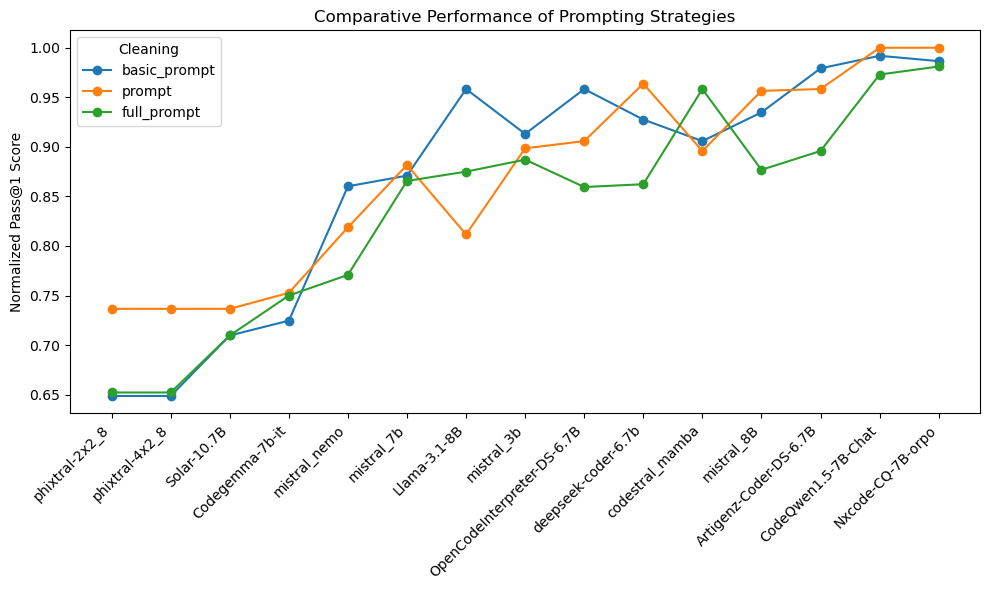

In [47]:
# visualize prompting strategy performance
plot_df = final_prompt_df.sort_values(by='mean')
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [48]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.max(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval,BigCode,MBPP,LBPP,Mean
prompt,,,,,
basic_prompt,0.804831,0.759498,0.778919,0.726389,0.804831
prompt,0.807246,0.778853,0.755135,0.698611,0.807246
full_prompt,0.745411,0.671326,0.752432,0.704167,0.752432
mean,0.785829,0.736559,0.762162,0.709722,0.788170


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 3.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [49]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval,BigCode,MBPP,LBPP,mean
CodeQwen1.5-7B-Chat,0.978261,0.779570,0.991892,0.791667,0.991892
Nxcode-CQ-7B-orpo,0.985507,0.752688,0.986486,0.770833,0.986486
Artigenz-Coder-DS-6.7B,0.891304,0.763441,0.875676,0.979167,0.979167
Llama-3.1-8B,0.840580,0.666667,0.816216,0.958333,0.958333
OpenCodeInterpreter-DS-6.7B,0.905797,0.677419,0.851351,0.958333,0.958333
mistral_8B,0.934783,0.892473,0.802703,0.750000,0.934783
deepseek-coder-6.7b,0.927536,0.747312,0.870270,0.791667,0.927536
mistral_3b,0.913043,0.892473,0.748649,0.708333,0.913043
codestral_mamba,0.905797,0.860215,0.789189,0.854167,0.905797
mistral_7b,0.500000,0.870968,0.570270,0.416667,0.870968


In [28]:
combined.head(25)

phixtral-2x2_8  phixtral-4x2_8  \
dataset   prompt       cleaning                                     
HumanEval basic_prompt raw               0.594203        0.594203   
                       partial           0.594203        0.594203   
                       full              0.608696        0.608696   
                       full_light        0.601449        0.601449   
          prompt       raw               0.028986        0.028986   
                       partial           0.550725        0.550725   
                       full              0.659420        0.659420   
                       full_light        0.666667        0.666667   
          full_prompt  raw               0.057971        0.057971   
                       partial           0.304348        0.304348   
                       full              0.652174        0.652174   
                       full_light        0.644928        0.644928   
BigCode   basic_prompt raw               0.306452        0.306452   
                       partial           0.317204        0.311828   
                       full              0.596774        0.602151   
                       full_light        0.397849        0.403226   
          prompt       raw               0.005376        0.005376   
                       partial           0.704301        0.704301   
                       full              0.736559        0.736559   
                       full_light        0.725806        0.725806   
          full_prompt  raw               0.043011        0.043011   
                       partial           0.080645        0.080645   
                       full              0.612903        0.612903   
                       full_light        0.537634        0.537634   
MBPP      basic_prompt raw               0.000000        0.000000   

                                   Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
dataset   prompt       cleaning                                                 
HumanEval basic_prompt raw            0.065217      0.000000         0.000000   
                       partial        0.536232      0.833333         0.724638   
                       full           0.536232      0.840580         0.724638   
                       full_light     0.536232      0.833333         0.724638   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.528986      0.782609         0.659420   
                       full           0.528986      0.811594         0.695652   
                       full_light     0.528986      0.797101         0.695652   
          full_prompt  raw            0.000000      0.000000         0.000000   
                       partial        0.405797      0.695652         0.608696   
                       full           0.492754      0.695652         0.644928   
                       full_light     0.492754      0.695652         0.644928   
BigCode   basic_prompt raw            0.177419      0.000000         0.000000   
                       partial        0.698925      0.586022         0.715054   
                       full           0.709677      0.666667         0.720430   
                       full_light     0.704301      0.607527         0.720430   
          prompt       raw            0.000000      0.000000         0.000000   
                       partial        0.736559      0.553763         0.758065   
                       full           0.736559      0.650538         0.752688   
                       full_light     0.736559      0.559140         0.752688   
          full_prompt  raw            0.000000      0.005376         0.000000   
                       partial        0.763441      0.806452         0.709677   
                       full           0.709677      0.801075         0.666667   
                       full_light     0.709677      0.801075         0.666667   
MBPP      basic_prompt raw            0.016216      0.027027     

In [27]:
best_case_df

,phixtral-2x2_8,phixtral-4x2_8,Solar-10.7B,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_7b,mistral_3b,mistral_8B,mistral_nemo,codestral_mamba
dataset,,,,,,,,,,,,,,,
HumanEval,0.608696,0.608696,0.536232,0.840580,0.724638,0.927536,0.905797,0.891304,0.978261,0.985507,0.500000,0.913043,0.934783,0.811594,0.905797
BigCode,0.596774,0.602151,0.709677,0.666667,0.720430,0.747312,0.677419,0.763441,0.779570,0.752688,0.870968,0.892473,0.892473,0.860215,0.860215
MBPP,0.648649,0.648649,0.605405,0.816216,0.721622,0.870270,0.851351,0.875676,0.991892,0.986486,0.570270,0.748649,0.802703,0.756757,0.789189
LBPP,0.562500,0.562500,0.395833,0.958333,0.625000,0.791667,0.958333,0.979167,0.791667,0.770833,0.416667,0.708333,0.750000,0.770833,0.854167


## Get Max Across All Prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [18]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').max()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['Max'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='Max', ascending=False)

# View result
model_perf_df

dataset,BigCode,HumanEval,LBPP,MBPP,Max
CodeQwen1.5-7B-Chat,0.784946,1.000000,0.812500,0.991892,1.000000
Nxcode-CQ-7B-orpo,0.774194,0.985507,0.791667,1.000000,1.000000
Artigenz-Coder-DS-6.7B,0.763441,0.905797,0.979167,0.875676,0.979167
deepseek-coder-6.7b,0.801075,0.963768,0.791667,0.870270,0.963768
Llama-3.1-8B,0.801075,0.840580,0.958333,0.821622,0.958333
OpenCodeInterpreter-DS-6.7B,0.779570,0.905797,0.958333,0.862162,0.958333
codestral_mamba,0.860215,0.905797,0.958333,0.789189,0.958333
mistral_8B,0.892473,0.956522,0.791667,0.802703,0.956522
mistral_3b,0.892473,0.913043,0.708333,0.748649,0.913043
mistral_7b,0.881720,0.500000,0.479167,0.570270,0.881720
